In [ ]:
"""
created by:
Nick Roseveare, Nov 2018, nicholasroseveare AT gmail.com
"""

## NOTES
Looking at this reference on EEG: https://en.wikipedia.org/wiki/Electroencephalography
a cursory review shows that Beta and Gamma waves 16-32Hz, and >32Hz are most related to active thinking, and even short-term memory/pattern matching tasks.

## Feature analysis ideas
   * Based on the above we could try taking coefficients from a FFT or power spectral density
   * Since there are a lot of possible native 'features', we might try a data reduction technique like PCA to exact combinations of feature that correspond to 'designed' features that contain more relevant information about the underlying signal
   * Similarly, we can use correlation analysis (and/or PCA) to find features correlated for one group that are more or less uncorrelated for the other group, thus, keeping these specific pairs should provide some discriminating features
   * Along with a reduction in the features considered useful, we can try a naive Bayes with a few moment statistics as inputs 
   * Leaning toward PCA-reduced or correlation-based sub-selection of frequency/PSD features from individual sensors combined via PCA dominant eigen-vectors; 
   * Can also try with manually selected frequency features based on Gamma and Beta wave frequencies
   * create encoder for one-hot on the match types (or just create three models), use 'alcoholic' or 'subject' as label


In [1]:
from eeg_project.read_data import (import_eeg_file, GetClassId,
    my_read_eeg_generic, senlist_known, match_types, SAMP_FREQ,
    accumulate_subject_file_list, PSD_on_row_data, pass_through, zero, PSD_on_row_data, fft_on_row_data,
    eeg_half_half_alcoholic_all_subjects_obj_40, eeg_half_half_alcoholic_all_subjects_obj_100,
    eeg_half_half_alcoholic_all_subjects_match_100, eeg_half_half_alcoholic_all_subjects_nomatch_100,
    get_all_metadata, sample_file_list, get_blocked_data)
from eeg_project.plot_data import (plot_data_subject_dirs, highlight_correlated_feature_twoclass)
from sklearn.metrics import accuracy_score, f1_score, make_scorer
import numpy as np
import pandas as pd
import os

from six import text_type
import gzip, bz2
import tqdm 
from collections import defaultdict

from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
# import ipywidgets as widgets
from IPython.display import display, clear_output
# %matplotlib notebook

data_dir = 'small_data_set'
data_dirs = [f'./{data_dir}/SMNI_CMI_TRAIN', f'./{data_dir}/SMNI_CMI_TEST']

  1%|          | 1/100 [00:00<00:17,  5.71it/s]

getting example data for match_type[match] and is_alcoholic[True]


  1%|          | 1/100 [00:00<00:11,  8.60it/s]

getting example data for match_type[match] and is_alcoholic[False]


100%|██████████| 100/100 [00:12<00:00,  8.00it/s]


SVec size (64, 64)


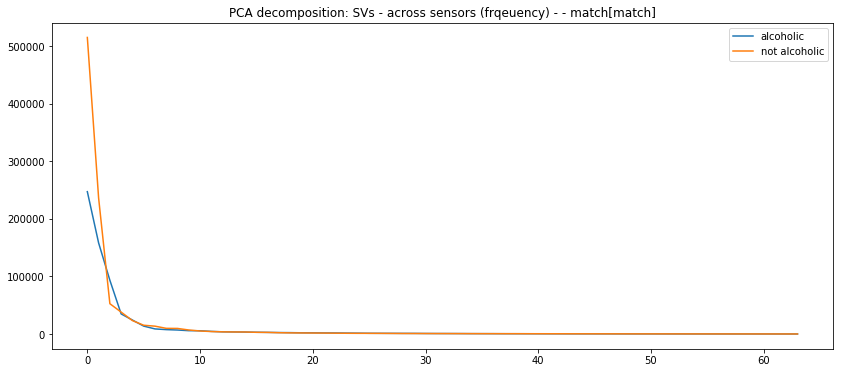

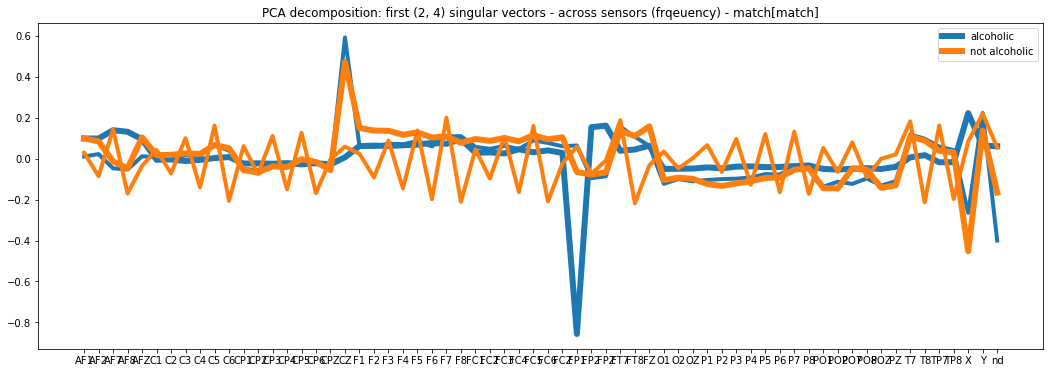

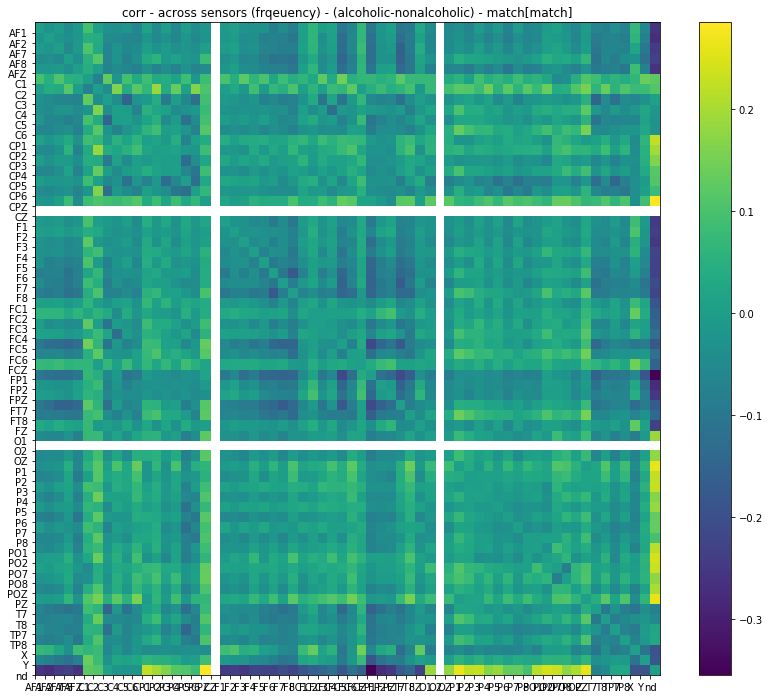

TypeError: slice indices must be integers or None or have an __index__ method

In [2]:
Ua, Una = highlight_correlated_feature_twoclass(100, process_data=fft_on_row_data,
    pca_vec_to_plot=(2, 4),
    match_types_in=['match'], figsize=(14, 12), debug=1)

In [6]:
data_tuple = get_blocked_data(
#         process_data=fft_on_row_data, pickle_name='eeg_all_data_medium_size_1200.fft.bin')
    pickle_name='eeg_all_data_medium_size_1200.fft.bin',
    debug=2)
    
# data_tuple = get_blocked_data(
#     process_data=fft_on_row_data, pickle_name='eeg_all_data_medium_size_1200.fft.bin')

# data_tuple = get_blocked_data(eeg_half_half_alcoholic_all_subjects_obj_tt_even_400,
# #         process_data=fft_on_row_data, pickle_name='eeg_half_half_alcoholic_all_subjects_obj_tt_even_400.fft.bin')
#     pickle_name='eeg_half_half_alcoholic_all_subjects_obj_tt_even_400.bin')
if len(data_tuple) > 5:
    multi_class = True
    X_train, y_train, X_test, y_test, uses_cat_feat, classIdDict = data_tuple
else:
    X_train, y_train, X_test, y_test, uses_cat_feat = data_tuple
    
X_train, X_test = X_train.numpy(), X_test.numpy()
y_train, y_test = y_train.numpy(), y_test.numpy()


X_train = X_train.reshape(
        (X_train.shape[0], (X_train.shape[2] * X_train.shape[3])))
X_test = X_test.reshape(
        (X_test.shape[0], (X_test.shape[2] * X_test.shape[3])))

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

reading binary of organized data

   Xtrain:torch.Size([600, 1, 256, 64])
   ytrain:torch.Size([600])
   Xtest:torch.Size([600, 1, 256, 64])
   ytest:torch.Size([600])
   is multi-class: False
   use 1-hot categorical feats: False


In [15]:
import numpy as np

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

clf = SVC(C=0.7, cache_size=200, class_weight=None, coef0=0.0,
    gamma='scale', kernel='rbf',
    max_iter=1000, tol=0.001)
#     probability=False, random_state=None, shrinking=True,
#     , verbose=False)

In [7]:
# Xtrain_fmapped = np.zeros((Xtrain.shape[0], 2))
# Xtrain_fmapped[(y_train == 1), :] = np.matmul(Ua[:, 1:3].transpose(), Xtrain[(y_train == 1), 0, :, :] 
# Xtrain_fmapped[(y_train == 0), :] = np.matmul(Una[:, 1:3].transpose(), Xtrain[(y_train == 0), 0, :, :] 

# scaler = preprocessing.StandardScaler().fit(Xtrain_fmapped)

# scaler = StandardScaler().fit(X_train)
                                              
# Xtest_fmapped[(y_test == 1), :] = np.matmul(Ua[:, 1:3].transpose(), Xtrain[(y_test == 1), 0, :, :]                                              
# Xtest_fmapped[(y_test == 0), :] = np.matmul(Ua[:, 1:3].transpose(), Xtrain[(y_test == 1), 0, :, :]                                              
                                              
# clf.fit(Xtrain_fmapped, y_train)

clf.fit(X_train, y_train) 


# pred = clf.predict(scaler.transform(Xtest_fmapped))
pred_tr = clf.predict(X_train)
pred = clf.predict(X_test)

print(f'accurracy: {accuracy_score(pred_tr, y_train)}|{accuracy_score(pred, y_test)},'
      f' F-1: {f1_score(pred_tr, y_train)}|{f1_score(pred, y_test)}')

accurracy: 0.96|0.6633333333333333, F-1: 0.9606557377049181|0.6720779220779222


In [16]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':[0.2, 0.5, 1.2], 'gamma': ['scale', 'auto']}

clf = GridSearchCV(clf, parameters, cv=None, scoring=make_scorer(f1_score))

clf.fit(X_train, y_train)

/Users/nick/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv=None, error_score='raise-deprecating',
       estimator=SVC(C=0.7, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.2, 0.5, 1.2], 'gamma': ['scale', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=0)

In [17]:
clf.cv_results_

/Users/nick/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nick/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nick/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nick/anaconda3/lib/python3.

{'mean_fit_time': array([  2.48248164,   2.40584795,   2.33047962,   2.29081559,
        669.87940892,   3.21603958]),
 'std_fit_time': array([1.02785772e-01, 8.97873368e-02, 5.49187217e-02, 3.60288560e-02,
        9.44069227e+02, 1.27697690e+00]),
 'mean_score_time': array([1.19146204, 1.16024494, 1.13061603, 1.12489891, 1.26685667,
        1.18019255]),
 'std_score_time': array([0.05650754, 0.02004188, 0.03245023, 0.02794994, 0.17190625,
        0.05360779]),
 'param_C': masked_array(data=[0.2, 0.2, 0.5, 0.5, 1.2, 1.2],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=['scale', 'auto', 'scale', 'auto', 'scale', 'auto'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.2, 'gamma': 'scale'},
  {'C': 0.2, 'gamma': 'auto'},
  {'C': 0.5, 'gamma': 'scale'},
  {'C': 0.5, 'gamma': 'auto'},
  {'C': 1.2, 'gamma

In [2]:
# subject_data = pd.DataFrame({})
# frame_list = []
# for file in half_half_alcoholic_all_subjects_40:
#     frame, info = my_read_eeg_generic(file, orig_tt_indic=('test' in file))
# #     frame = pd.read_csv(file, names=columns)
#     frame_list.append(frame)
    
# subject_data = pd.concat(frame_list, axis=0, join_axes=[frame.index, frame.columns])  # , ignore_index=True)
                                  
# subject_data